In [80]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [44]:
import numpy as np
import random
import pandas as pd
import tqdm
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data


import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for i, filename in enumerate(filenames):
#         if i<5:
#             print(os.path.join(dirname,filename))

/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # Remove the CWD from sys.path while we load stuff.


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
df = pd.read_csv('../data/MNQ DEC23.Last-500-Volume-Action.csv')
df.head()

,date,open,high,low,close,vol,ft,action
0,2023-10-02 22:00:38,14992.00,14992.25,14986.50,14989.50,500,-0.342828,0
1,2023-10-02 22:03:41,14989.75,14992.50,14988.25,14990.50,500,-0.062081,0
2,2023-10-02 22:08:04,14991.00,14992.75,14989.50,14992.00,500,0.396141,0
3,2023-10-02 22:13:26,14992.00,14995.00,14987.75,14989.75,500,0.204056,0
4,2023-10-02 22:14:44,14989.75,14999.00,14989.75,14997.50,500,0.449363,0


In [4]:
dfi =df[['close']]

In [5]:
scaler = MinMaxScaler(feature_range=(-1, 1))
dfi['close'] = scaler.fit_transform(dfi['close'].values.reshape(-1,1))

/home/shmalex/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [61]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(dfi, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (49418, 59, 1)
y_train.shape =  (49418, 1)
x_test.shape =  (12355, 59, 1)
y_test.shape =  (12355, 1)


In [62]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)

In [63]:
x_train.device,x_test.device,y_train.device,y_test.device

(device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0))

In [64]:
train_loader = data.DataLoader(data.TensorDataset(x_train, y_train), shuffle=True, batch_size=256)
test_loader = data.DataLoader(data.TensorDataset(x_test, y_test), shuffle=True, batch_size=256)

In [65]:
y_train.size(),x_train.size()


(torch.Size([49418, 1]), torch.Size([49418, 59, 1]))

In [66]:
# Build model
#####################
input_dim = 1
hidden_dim = 64
num_layers = 2 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True).to(device)
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim).to(device)
        self.to(device)
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

loss_fn = torch.nn.MSELoss().to(device)

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
10
torch.Size([256, 1])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([256, 64])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([1, 64])
torch.Size([1])


In [67]:
print(model.to(device))

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [68]:
x_train.shape

torch.Size([49418, 59, 1])

In [81]:
y_batch_pred = model(X_batch)

In [ ]:
x_b

In [84]:
loss_fn(y_batch_pred, y_batch)

tensor(4.4510e-05, device='cuda:0', grad_fn=<MseLossBackward>)

In [82]:
y_batch_pred

tensor([[ 0.5892],
        [ 0.4824],
        [-0.1052],
        [ 0.8376],
        [ 0.1298],
        [ 0.7781],
        [ 0.5884],
        [-0.0559],
        [ 0.1451],
        [ 0.0524]], device='cuda:0', grad_fn=<AddmmBackward>)

In [69]:
# Train model
#####################
num_epochs = 200
# hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  
step = 0
hist = []
for ep in tqdm.notebook.tqdm_notebook(range(num_epochs), desc='Epoch'):
    for X_batch, y_batch in tqdm.notebook.tqdm_notebook(train_loader, desc='Batch', leave=False):
        step += 1
        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        #model.hidden = model.init_hidden()

        # Forward pass
        y_batch_pred = model(X_batch)

        loss = loss_fn(y_batch_pred, y_batch)
        hist.append(loss.item()))
#         if step % 10 == 0 and step !=0:
#             print("Epoch ", t, "MSE: ", loss.item())

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()

In [73]:
hist = [h.item() for h in hist]

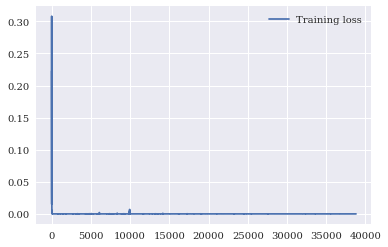

In [74]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

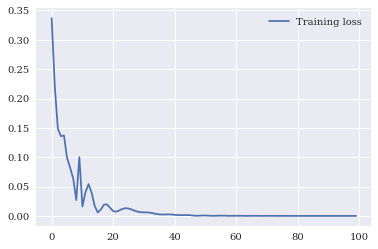

In [29]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [75]:

np.shape(y_train_pred)


(49418, 1)

In [76]:
x_test.shape

torch.Size([12355, 59, 1])

In [79]:
# make predictions
y_train_pred = model(x_train)
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.cpu().detach().numpy())
y_train = scaler.inverse_transform(y_train.cpu().detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.cpu().detach().numpy())
y_test = scaler.inverse_transform(y_test.cpu().detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

RuntimeError: CUDA out of memory. Tried to allocate 7.65 GiB (GPU 0; 10.75 GiB total capacity; 3.95 GiB already allocated; 3.23 GiB free; 6.15 GiB reserved in total by PyTorch)

In [35]:
y_test_pred.shape

(12355, 1)

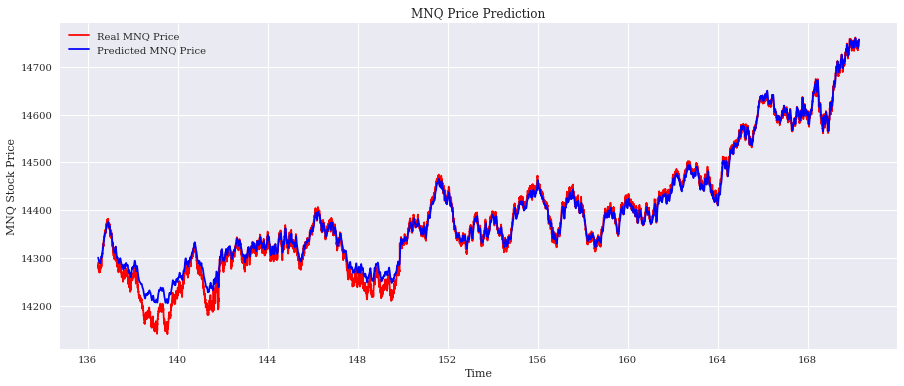

In [33]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df[len(df)-len(y_test):].index, y_test, color = 'red', label = 'Real MNQ Price')
axes.plot(df[len(df)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted MNQ Price')
#axes.xticks(np.arange(0,394,50))
plt.title('MNQ Price Prediction')
plt.xlabel('Time')
plt.ylabel('MNQ Stock Price')
plt.legend()
# plt.savefig('ibm_pred.png')
plt.show()